In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
import pandas as pd
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import Point

import rasterio
import tables as tab
import tqdm.notebook as tqdm
from skimage.transform import  AffineTransform
from rasterio.transform import Affine
from skimage.measure import ransac
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, SIFT
from PIL import Image
import re
import math, requests
import io
import tqdm
import sys



from PRISMA_georeference import GoogleMapDownloader, GoogleMapsLayers, pixel_to_latlon, latlon_to_pix, prisma_2_tiff, match_subblocks

In [9]:
MATCHING_CUTOFF = 0.7
SEP_CUTOFF = 0.01

def adjust_lat_lon(path_to_PRISMA_file, outpath="", band_for_rgb = 20):
    '''
    path_to_PRISMA_file - should be the full path so that re works
    '''
    zoom_level = 11
    tile_width = 7
    tile_height = 7
    
    
    metrics = {}
    print("# 1 create .tif file")
    tiff_output = outpath + '.tif'
    mean_lat, mean_lon = prisma_2_tiff(path_to_PRISMA_file, tiff_output, band_for_rgb)
    
    print("# 2 Download gmaps for the same location")
    gmd = GoogleMapDownloader(mean_lat, mean_lon, zoom_level,
                              GoogleMapsLayers.SATELLITE)
    img, tile_coords_corner = gmd.generateImage(tile_width=tile_width,
                                                tile_height=tile_height)
    
    print(" 3 Determine matched features in PRISMA image to gMaps image with SIFT")
    tif_coords, gmaps_coords, nmatches = \
        match_subblocks(tiff_output, tile_coords_corner, img, cutoff=MATCHING_CUTOFF)
    metrics['n_matches'] = nmatches
    del img
    
    orig_errs = np.sqrt(np.sum((tif_coords-gmaps_coords)**2, axis=1))
    metrics['orig_mean_error'] = orig_errs.mean()
    
    keep = orig_errs < SEP_CUTOFF
    src = np.array(tif_coords[keep])
    dst = np.array(gmaps_coords[keep])
    
    
    print(" 4 Define mapping between PRISMA LatLon and gMaps latlon")
    mapping, inliers = ransac((src, dst), AffineTransform, min_samples=4,
                               residual_threshold=0.002, max_trials=100)
    new_errs = np.sqrt(np.sum((mapping(src)-dst)**2, axis=1))
    metrics['new_mean_error'] = new_errs.mean()
    
    n_outliers = np.sum(~inliers)
    metrics['n_outliers'] = n_outliers
    
    print(" 5 Map PRISMA Latlons to gMaps latlons (ransac affine) and save for reference")
    orig = rasterio.open(tiff_output)
    adjusted_latlon = mapping(np.vstack([orig.read(2).flatten(),
                                        orig.read(3).flatten()]).transpose())
    orig.close()
    adjusted_latlon = adjusted_latlon.reshape((1000,1000,2))
    #np.savez(outpath + "_adjll.npz", adjusted_latlon = adjusted_latlon)
    np.save(outpath + ".npy", adjusted_latlon)
    return adjusted_latlon, metrics

In [17]:
dir_path = r"C:\Users\simon\Documents\Skole\EIT\Tare_Naturbase"
prisma_path = "HyperSpectral4.he5"
prisma_path = dir_path + "/" + prisma_path
outpath = "out/band_550"

adjusted = adjust_lat_lon(prisma_path, outpath, band_for_rgb=15)

# 1 create .tif file
# 2 Download gmaps for the same location
Image size (pix):  (1792, 1792)
Tile coordinate top left (north-west) corner: 1048,568
 3 Determine matched features in PRISMA image to gMaps image with SIFT


100%|██████████| 81/81 [00:15<00:00,  5.33it/s]


 4 Define mapping between PRISMA LatLon and gMaps latlon
 5 Map PRISMA Latlons to gMaps latlons (ransac affine) and save for reference


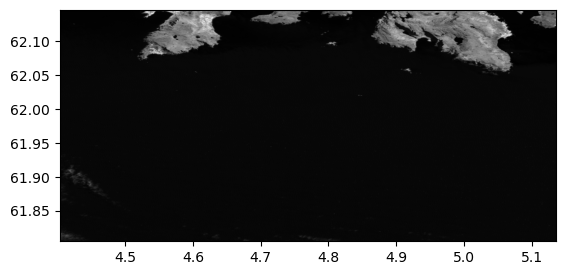

In [18]:
from rasterio.plot import show
with rasterio.open(r"out/band_550.tif") as src:
    fig, ax = plt.subplots()

    # transform rasterio plot to real world coords
    extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='gray')
    src.close()

In [36]:
raster_550 = rasterio.open(r"out/band_550.tif")
band_550 = raster_550.read(1)

raster_490 = rasterio.open(r"out/band_490.tif")
band_490 = raster_490.read(1)

print(raster_490.read().shape)

subtracted = band_550 - band_490

subtracted


(3, 1000, 1000)


array([[ 132.,  133.,  160., ..., 1426., 1519., 1424.],
       [ 131.,  130.,  154., ..., 1468., 1549., 1379.],
       [ 160.,  146.,  133., ..., 1387., 1412., 1347.],
       ...,
       [ 450.,  369.,  386., ...,  191.,  224.,  218.],
       [ 436.,  295.,  310., ...,  197.,  268.,  213.],
       [ 346.,  271.,  296., ...,  216.,  231.,  181.]], dtype=float32)

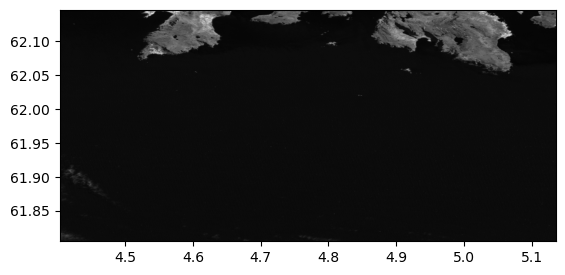

In [31]:
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[raster_550.bounds[0], raster_550.bounds[2], raster_550.bounds[1], raster_550.bounds[3]]
ax = rasterio.plot.show(subtracted, extent=extent, ax=ax, cmap='gray')

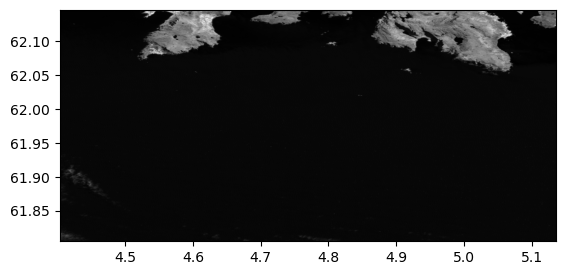

In [32]:
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[raster_550.bounds[0], raster_550.bounds[2], raster_550.bounds[1], raster_550.bounds[3]]
ax = rasterio.plot.show(raster_550, extent=extent, ax=ax, cmap='gray')